<a href="https://colab.research.google.com/github/alemack/ts-patching-experiments/blob/main/notebooks/FordB_baseline_rawpatches_RL_Lsweep_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft

from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve

In [21]:
# --- Пути проекта ---
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/FordB")
DATA_DIR    = PROJECT_DIR / "data" / "raw"
RESULTS_DIR = PROJECT_DIR / "results" / "patching_baseline"

# создаём папки, если их нет
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR, "exists:", PROJECT_DIR.exists())
print("DATA_DIR   :", DATA_DIR,    "exists:", DATA_DIR.exists())
print("RESULTS_DIR:", RESULTS_DIR, "exists:", RESULTS_DIR.exists())

# посмотреть что лежит в основных папках
print("\nDATA files:")
print(*sorted(glob.glob(str(DATA_DIR/"*"))), sep="\n")
print("\nRESULT files:")
print(*sorted(glob.glob(str(RESULTS_DIR/"*"))), sep="\n")

PROJECT_DIR: /content/drive/MyDrive/Colab Notebooks/FordB exists: True
DATA_DIR   : /content/drive/MyDrive/Colab Notebooks/FordB/data/raw exists: True
RESULTS_DIR: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline exists: True

DATA files:
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB.txt
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TEST.arff
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TEST.ts
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TEST.txt
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TRAIN.arff
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TRAIN.ts
/content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TRAIN.txt

RESULT files:
/content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_auc_vs_L_top1_aggmax_q0.8.pdf
/content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_auc_vs_L_top1_aggmax_q0.8.png
/content/drive/MyDrive/Colab 

In [ ]:
train_path = DATA_DIR / "FordB_TRAIN.txt"
test_path  = DATA_DIR / "FordB_TEST.txt"

print("Train path:", train_path)
print("Test  path:", test_path)

# 1) Быстрый просмотр первых 2 строк (как текст)
with open(train_path, "r") as f:
    for _ in range(2):
        print(f.readline()[:200])  # 200 символов, чтобы не засорять вывод

# 2) Загрузка как числа
train = np.loadtxt(train_path)
test  = np.loadtxt(test_path)

print("TRAIN shape:", train.shape)  # ожидаем (3636, 501) -> 1 метка + 500 значений
print("TEST  shape:", test.shape)   # ожидаем (810, 501)

y_train = train[:, 0]
X_train = train[:, 1:]
y_test  = test[:, 0]
X_test  = test[:, 1:]

print("X_train:", X_train.shape, "y_train unique:", np.unique(y_train))
print("X_test :", X_test.shape,  "y_test unique:", np.unique(y_test))
print("Series length:", X_train.shape[1])

Train path: /content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TRAIN.txt
Test  path: /content/drive/MyDrive/Colab Notebooks/FordB/data/raw/FordB_TEST.txt
   1.0000000e+00  -7.3126908e-01  -3.3170917e-01   1.8021198e-01   7.2935568e-01   1.2267202e+00   1.5848643e+00   1.7190977e+00   1.6224040e+00   1.3496154e+00   9.5758584e-01   5.1770889e-01   8.550
  -1.0000000e+00   1.6259232e+00   1.1748872e+00   6.3355733e-01   9.7815282e-02  -3.2397894e-01  -5.2268152e-01  -5.0107844e-01  -3.0993678e-01  -5.3305364e-02   7.4494560e-02   5.6764086e-02  -1.080
TRAIN shape: (3636, 501)
TEST  shape: (810, 501)
X_train: (3636, 500) y_train unique: [-1.  1.]
X_test : (810, 500) y_test unique: [-1.  1.]
Series length: 500


In [ ]:
def to01(y):
    u = np.unique(y)
    if set(u) == {-1.0, 1.0}:
        return (y == 1.0).astype(int)
    if set(u) == {1.0, 2.0}:
        return (y == 2.0).astype(int)
    return y

y_train01 = to01(y_train)
y_test01  = to01(y_test)

print("Unique y_train01:", np.unique(y_train01), "Unique y_test01:", np.unique(y_test01))


Unique y_train01: [0 1] Unique y_test01: [0 1]


In [ ]:
def zscore_per_series(X):
    """
    X: (n_series, T)
    Возвращает нормализованный X, где каждая серия имеет mean=0 и std=1.
    """
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    sd = np.where(sd < 1e-8, 1.0, sd)  # защита от деления на 0
    return (X - mu) / sd


In [ ]:
def make_patches_no_overlap(X, y, L):
    """
    X: (n_series, T), y: (n_series,)
    Возвращает:
      Xp: (n_series*K, L)  - все патчи
      yp: (n_series*K,)    - метка для каждого патча (наследуется от ряда)
      series_id: (n_series*K,) - номер исходного ряда для каждого патча
      K: число патчей на ряд
    """
    # на данный момент хвост отбрасывается
    n, T = X.shape
    K = T // L  # сколько патчей по L без перекрытия (для T=500)
    Xp = X[:, :K*L].reshape(n*K, L)       # (n*K, L)
    yp = np.repeat(y, K)                 # (n*K,)
    series_id = np.repeat(np.arange(n), K)  # (n*K,) - нужно для агрегации
    return Xp, yp, series_id, K


In [ ]:
def series_scores_from_patch_scores(score_patch, series_id, n_series, agg="max"):
    """
    score_patch: (n_patches,) непрерывный score патча (чем больше, тем "аномальнее")
    series_id:   (n_patches,) индекс ряда для каждого патча
    agg: 'max' или 'mean'
    Возвращает series_scores: (n_series,)
    """
    if agg == "max":
        series_scores = np.full(n_series, -np.inf, dtype=float)
        for s, sid in zip(score_patch, series_id):
            if s > series_scores[sid]:
                series_scores[sid] = s
        return series_scores

    if agg == "mean":
        sums = np.zeros(n_series, dtype=float)
        cnts = np.zeros(n_series, dtype=int)
        for s, sid in zip(score_patch, series_id):
            sums[sid] += s
            cnts[sid] += 1
        return sums / np.maximum(cnts, 1)

    raise ValueError("agg must be 'max' or 'mean'")

In [ ]:
# --- Grid по q_thr для supervised моделей (LR / NB / SVM) ---
# Цель: подобрать q_thr так, чтобы pred_pos_rate был не ~0 и не ~1,
# и при этом F1 был разумным.

def agg_series_from_patch_scores(score_patch, series_id, n_series, agg="max"):
    """score_patch: (n_patches,), series_id: (n_patches,)"""
    if agg == "max":
        out = np.full(n_series, -np.inf, dtype=float)
        for s, sid in zip(score_patch, series_id):
            if s > out[sid]:
                out[sid] = s
        return out

    if agg == "mean":
        sums = np.zeros(n_series, dtype=float)
        cnts = np.zeros(n_series, dtype=int)
        for s, sid in zip(score_patch, series_id):
            sums[sid] += s
            cnts[sid] += 1
        return sums / np.maximum(cnts, 1)

    raise ValueError("agg must be 'max' or 'mean'")


def eval_L_supervised_3models_qthr(
    X_train, y_train01, X_test, y_test01,
    L,
    agg_series="max",
    q_thr=0.995
):
    """
    3 supervised модели: LR, GaussianNB, LinearSVC.
    Патч = raw values (после z-score по ряду), stride=L.
    Score ряда = agg(score патчей).
    Порог thr выбираем по train-норме: quantile(score_tr_series[y_train==0], q_thr).
    Метрики: AUC (по score ряда), P/R/F1 (по thr), pred_pos_rate.
    """

    # 1) z-score per series
    Xtr = zscore_per_series(X_train)
    Xte = zscore_per_series(X_test)

    # 2) patches (stride=L)
    Xtr_p, ytr_p, sid_tr, _ = make_patches_no_overlap(Xtr, y_train01, L)
    Xte_p, yte_p, sid_te, _ = make_patches_no_overlap(Xte, y_test01, L)

    n_train_series = len(y_train01)
    n_test_series  = len(y_test01)

    # 3) scaling (важно для LR/SVM; NB тоже пусть будет в тех же координатах)
    scaler = StandardScaler()
    Xtr_ps = scaler.fit_transform(Xtr_p)
    Xte_ps = scaler.transform(Xte_p)

    rows = []

    # (A) Logistic Regression
    lr = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
    lr.fit(Xtr_ps, ytr_p)

    score_tr_patch = lr.predict_proba(Xtr_ps)[:, 1]
    score_te_patch = lr.predict_proba(Xte_ps)[:, 1]

    score_tr_series = agg_series_from_patch_scores(score_tr_patch, sid_tr, n_train_series, agg=agg_series)
    score_te_series = agg_series_from_patch_scores(score_te_patch, sid_te, n_test_series,  agg=agg_series)

    thr = float(np.quantile(score_tr_series[y_train01 == 0], q_thr))
    y_pred = (score_te_series >= thr).astype(int)

    auc = roc_auc_score(y_test01, score_te_series)
    p, r, f1, _ = precision_recall_fscore_support(y_test01, y_pred, average="binary", zero_division=0)

    rows.append({
        "model": "LogReg", "L": L, "agg": agg_series, "q_thr": q_thr,
        "thr": thr, "AUC": float(auc), "P": float(p), "R": float(r), "F1": float(f1),
        "pred_pos_rate": float(y_pred.mean())
    })

    # (B) Naive Bayes
    nb = GaussianNB()
    nb.fit(Xtr_ps, ytr_p)

    score_tr_patch = nb.predict_proba(Xtr_ps)[:, 1]
    score_te_patch = nb.predict_proba(Xte_ps)[:, 1]

    score_tr_series = agg_series_from_patch_scores(score_tr_patch, sid_tr, n_train_series, agg=agg_series)
    score_te_series = agg_series_from_patch_scores(score_te_patch, sid_te, n_test_series,  agg=agg_series)

    thr = float(np.quantile(score_tr_series[y_train01 == 0], q_thr))
    y_pred = (score_te_series >= thr).astype(int)

    auc = roc_auc_score(y_test01, score_te_series)
    p, r, f1, _ = precision_recall_fscore_support(y_test01, y_pred, average="binary", zero_division=0)

    rows.append({
        "model": "NaiveBayes", "L": L, "agg": agg_series, "q_thr": q_thr,
        "thr": thr, "AUC": float(auc), "P": float(p), "R": float(r), "F1": float(f1),
        "pred_pos_rate": float(y_pred.mean())
    })

    # (C) Linear SVM
    svm = LinearSVC(class_weight="balanced", max_iter=20000)
    svm.fit(Xtr_ps, ytr_p)

    score_tr_patch = svm.decision_function(Xtr_ps)
    score_te_patch = svm.decision_function(Xte_ps)

    score_tr_series = agg_series_from_patch_scores(score_tr_patch, sid_tr, n_train_series, agg=agg_series)
    score_te_series = agg_series_from_patch_scores(score_te_patch, sid_te, n_test_series,  agg=agg_series)

    thr = float(np.quantile(score_tr_series[y_train01 == 0], q_thr))
    y_pred = (score_te_series >= thr).astype(int)

    auc = roc_auc_score(y_test01, score_te_series)
    p, r, f1, _ = precision_recall_fscore_support(y_test01, y_pred, average="binary", zero_division=0)

    rows.append({
        "model": "SVM(Linear)", "L": L, "agg": agg_series, "q_thr": q_thr,
        "thr": thr, "AUC": float(auc), "P": float(p), "R": float(r), "F1": float(f1),
        "pred_pos_rate": float(y_pred.mean())
    })

    return rows


# RUN q_thr grid (быстро)
L_list = [8, 16, 32, 56, 64, 80]       # quick sanity-check
agg_series = "max"                      # попробуем сначала max
q_grid = [0.80, 0.90, 0.95, 0.97, 0.98, 0.99, 0.995]

rows = []
for q_thr in tqdm(q_grid, desc=f"q_thr grid (agg={agg_series})"):
    for L in L_list:
        rows.extend(eval_L_supervised_3models_qthr(
            X_train, y_train01, X_test, y_test01,
            L=L, agg_series=agg_series, q_thr=q_thr
        ))

df_grid = pd.DataFrame(rows)

# Таблица
print(df_grid.sort_values(["model","q_thr","L"]).to_string(index=False))

# Сводка: средний pred_pos_rate и лучший F1 по L для каждой (model, q_thr)
summary = (
    df_grid.groupby(["model","q_thr"], as_index=False)
           .agg(pred_pos_rate_mean=("pred_pos_rate","mean"),
                F1_best=("F1","max"),
                AUC_best=("AUC","max"))
           .sort_values(["model","F1_best"], ascending=[True, False])
)
print("\nSUMMARY:")
print(summary.to_string(index=False))

out_csv = RESULTS_DIR / f"fordb_qthr_grid_quick_{agg_series}.csv"
df_grid.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)


q_thr grid (agg=max):   0%|          | 0/7 [00:00<?, ?it/s]

      model  L agg  q_thr      thr      AUC        P        R       F1  pred_pos_rate
     LogReg  8 max  0.800 0.500420 0.557921 0.545455 0.322738 0.405530       0.298765
     LogReg 16 max  0.800 0.502964 0.540141 0.544304 0.105134 0.176230       0.097531
     LogReg 32 max  0.800 0.514773 0.489937 0.171429 0.014670 0.027027       0.043210
     LogReg 56 max  0.800 0.527066 0.482047 0.243243 0.022005 0.040359       0.045679
     LogReg 64 max  0.800 0.531946 0.440299 0.000000 0.000000 0.000000       0.038272
     LogReg 80 max  0.800 0.533414 0.507698 0.235294 0.019560 0.036117       0.041975
     LogReg  8 max  0.900 0.500460 0.557921 0.531746 0.163814 0.250467       0.155556
     LogReg 16 max  0.900 0.503376 0.540141 0.472222 0.041565 0.076404       0.044444
     LogReg 32 max  0.900 0.517125 0.489937 0.133333 0.004890 0.009434       0.018519
     LogReg 56 max  0.900 0.532755 0.482047 0.000000 0.000000 0.000000       0.020988
     LogReg 64 max  0.900 0.538878 0.440299 0.000000 0

In [ ]:
# Quick sweep по L: supervised (LogReg / NB / SVM) с порогом по train-норме (q_thr)

import pandas as pd
from tqdm.auto import tqdm

# Быстрый sanity-check: небольшой список L
L_list = [8, 16, 32, 56, 64, 80]

# ВАЖНО: берём тот самый "компромиссный" q_thr
agg_series = "max"
q_thr = 0.80   #  с 0.80 начнем

rows = []
for L in tqdm(L_list, desc=f"Quick sweep (agg={agg_series}, q_thr={q_thr})"):
    if 500 // L < 1:
        continue
    rows.extend(
        eval_L_supervised_3models_qthr(
            X_train, y_train01, X_test, y_test01,
            L=L,
            agg_series=agg_series,
            q_thr=q_thr
        )
    )

df_sweep = pd.DataFrame(rows)

print(df_sweep.sort_values(["model","L"]).to_string(index=False))

# 2) Лучшее L по F1 для каждой модели
best_by_model = (
    df_sweep.sort_values(["model","F1"], ascending=[True, False])
            .groupby("model", as_index=False)
            .head(1)
)
print("\nBest by model (by F1):")
print(best_by_model.to_string(index=False))

# 3) Проверка: доля предсказанных аномальных рядов
print("\nPredicted positive rate (series-level):")
print(df_sweep.pivot(index="L", columns="model", values="pred_pos_rate").to_string())

out_csv = RESULTS_DIR / f"fordb_supervised_3models_quick_qthr{q_thr}_agg{agg_series}.csv"
df_sweep.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)


Quick sweep (agg=max, q_thr=0.8):   0%|          | 0/6 [00:00<?, ?it/s]

      model  L agg  q_thr      thr      AUC        P        R       F1  pred_pos_rate
     LogReg  8 max    0.8 0.500420 0.557921 0.545455 0.322738 0.405530       0.298765
     LogReg 16 max    0.8 0.502964 0.540141 0.544304 0.105134 0.176230       0.097531
     LogReg 32 max    0.8 0.514773 0.489937 0.171429 0.014670 0.027027       0.043210
     LogReg 56 max    0.8 0.527066 0.482047 0.243243 0.022005 0.040359       0.045679
     LogReg 64 max    0.8 0.531946 0.440299 0.000000 0.000000 0.000000       0.038272
     LogReg 80 max    0.8 0.533414 0.507698 0.235294 0.019560 0.036117       0.041975
 NaiveBayes  8 max    0.8 0.502288 0.548385 0.578231 0.207824 0.305755       0.181481
 NaiveBayes 16 max    0.8 0.521998 0.531751 0.595376 0.251834 0.353952       0.213580
 NaiveBayes 32 max    0.8 0.587089 0.562939 0.570833 0.334963 0.422188       0.296296
 NaiveBayes 56 max    0.8 0.714637 0.522008 0.527473 0.352078 0.422287       0.337037
 NaiveBayes 64 max    0.8 0.702152 0.547939 0.557432 0

In [ ]:
# Full sweep по L=1..100: supervised (LogReg / NB / SVM) с порогом по train-норме (q_thr)

import pandas as pd
from tqdm.auto import tqdm

L_list = list(range(1, 101))   # 1..100
agg_series = "max"
q_thr = 0.80

rows = []
for L in tqdm(L_list, desc=f"Full sweep (agg={agg_series}, q_thr={q_thr})"):
    if 500 // L < 1:
        continue
    rows.extend(
        eval_L_supervised_3models_qthr(
            X_train, y_train01, X_test, y_test01,
            L=L,
            agg_series=agg_series,
            q_thr=q_thr
        )
    )

df_full = pd.DataFrame(rows)

print("Rows:", df_full.shape)
print(df_full.head(12).to_string(index=False))

# 2) Лучшее L по F1 для каждой модели
best_by_model = (
    df_full.sort_values(["model","F1"], ascending=[True, False])
           .groupby("model", as_index=False)
           .head(1)
)
print("\nBest by model (by F1):")
print(best_by_model.to_string(index=False))

out_csv = RESULTS_DIR / f"fordb_supervised_3models_full_L1_100_qthr{q_thr}_agg{agg_series}.csv"
df_full.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)


Full sweep (agg=max, q_thr=0.8):   0%|          | 0/100 [00:00<?, ?it/s]

Rows: (300, 10)
      model  L agg  q_thr           thr      AUC        P        R       F1  pred_pos_rate
     LogReg  1 max    0.8  5.000000e-01 0.500000 0.504938 1.000000 0.671042       1.000000
 NaiveBayes  1 max    0.8  4.884488e-01 0.534638 0.561224 0.268949 0.363636       0.241975
SVM(Linear)  1 max    0.8 -2.691635e-12 0.551208 0.536424 0.198044 0.289286       0.186420
     LogReg  2 max    0.8  5.000000e-01 0.500000 0.504938 1.000000 0.671042       1.000000
 NaiveBayes  2 max    0.8  4.884730e-01 0.549573 0.452055 0.080685 0.136929       0.090123
SVM(Linear)  2 max    0.8  7.598788e-05 0.557244 0.250000 0.031785 0.056399       0.064198
     LogReg  3 max    0.8  5.000000e-01 0.500000 0.504938 1.000000 0.671042       1.000000
 NaiveBayes  3 max    0.8  4.893480e-01 0.565762 0.549223 0.259169 0.352159       0.238272
SVM(Linear)  3 max    0.8  4.174340e-04 0.545933 0.568750 0.222494 0.319859       0.197531
     LogReg  4 max    0.8  5.000000e-01 0.500000 0.504938 1.000000 0.67104

Saved: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_examples_normal_anomaly.png


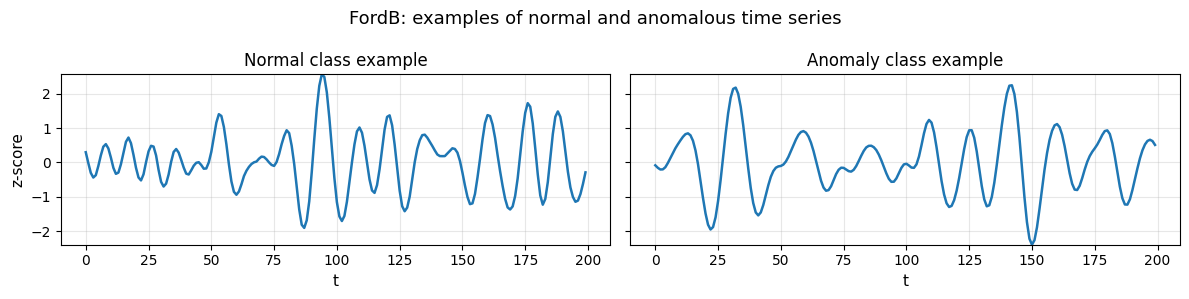

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T_show = 200
lw = 1.8
fs_title = 12
fs_label = 11

# Возьмём по одному примеру из TEST
idx_norm = np.where(y_test01 == 0)[0][0]
idx_anom = np.where(y_test01 == 1)[0][0]

x_norm = X_test[idx_norm]
x_anom = X_test[idx_anom]

# z-score по серии
x_norm_z = (x_norm - x_norm.mean()) / (x_norm.std() + 1e-12)
x_anom_z = (x_anom - x_anom.mean()) / (x_anom.std() + 1e-12)

x_norm_z = x_norm_z[:T_show]
x_anom_z = x_anom_z[:T_show]

# Общие пределы по Y
y_min = min(x_norm_z.min(), x_anom_z.min())
y_max = max(x_norm_z.max(), x_anom_z.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].plot(x_norm_z, lw=lw)
# axes[0].set_title(f"Normal (example, test idx={idx_norm})", fontsize=fs_title)
axes[0].set_title("Normal class example", fontsize=fs_title)
axes[0].set_xlabel("t", fontsize=fs_label)
axes[0].set_ylabel("z-score", fontsize=fs_label)
axes[0].set_ylim(y_min, y_max)
axes[0].grid(True, alpha=0.3)

axes[1].plot(x_anom_z, lw=lw)
# axes[1].set_title(f"Anomaly (example, test idx={idx_anom})", fontsize=fs_title)
axes[1].set_title("Anomaly class example", fontsize=fs_title)
axes[1].set_xlabel("t", fontsize=fs_label)
axes[1].set_ylim(y_min, y_max)
axes[1].grid(True, alpha=0.3)

fig.suptitle("FordB: examples of normal and anomalous time series", fontsize=13)
plt.tight_layout()

out_png = RESULTS_DIR / "fordb_examples_normal_anomaly.png"
plt.savefig(out_png, dpi=200, bbox_inches="tight")
print("Saved:", out_png)

plt.show()



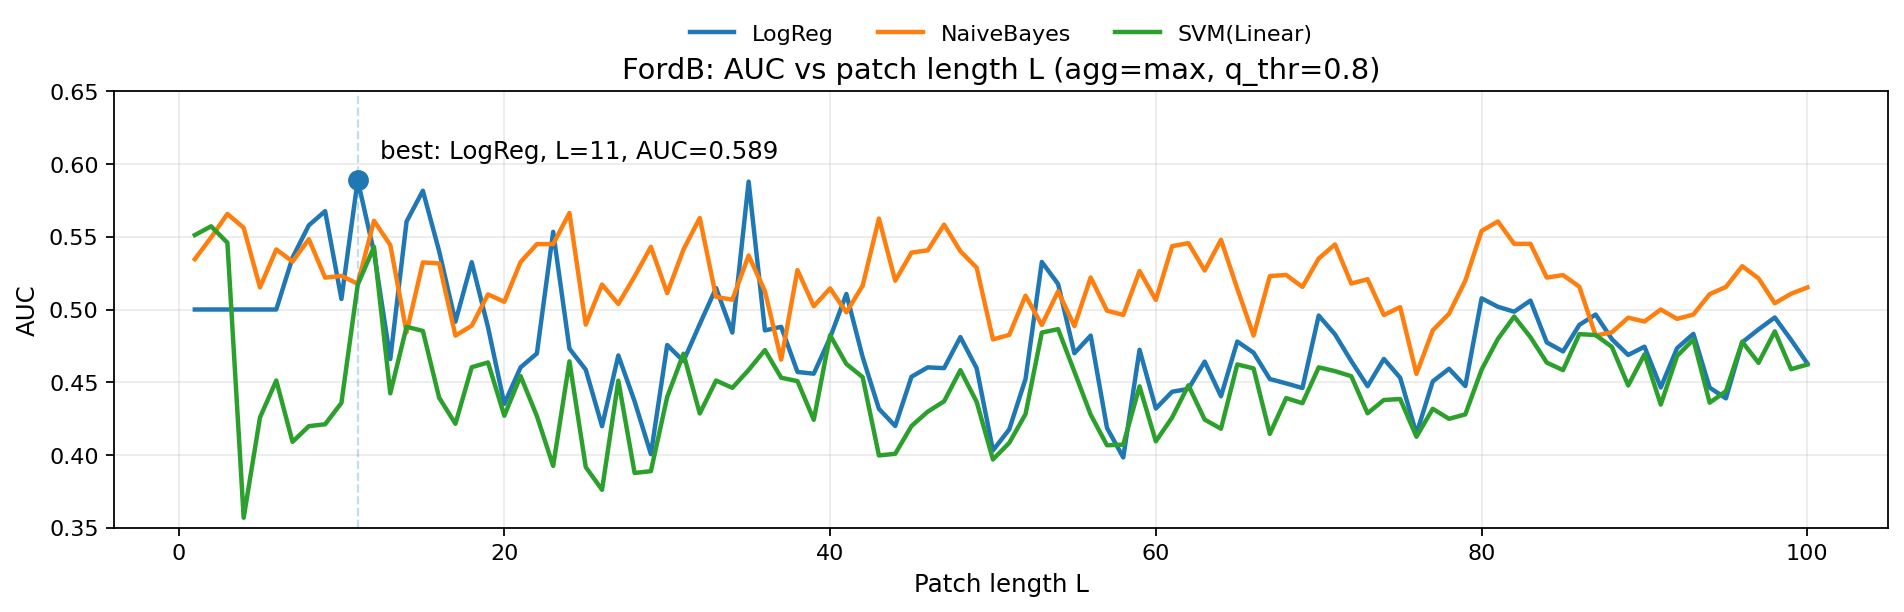

Saved PNG: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_auc_vs_L_top1_aggmax_q0.8.png
Saved PDF: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_auc_vs_L_top1_aggmax_q0.8.pdf


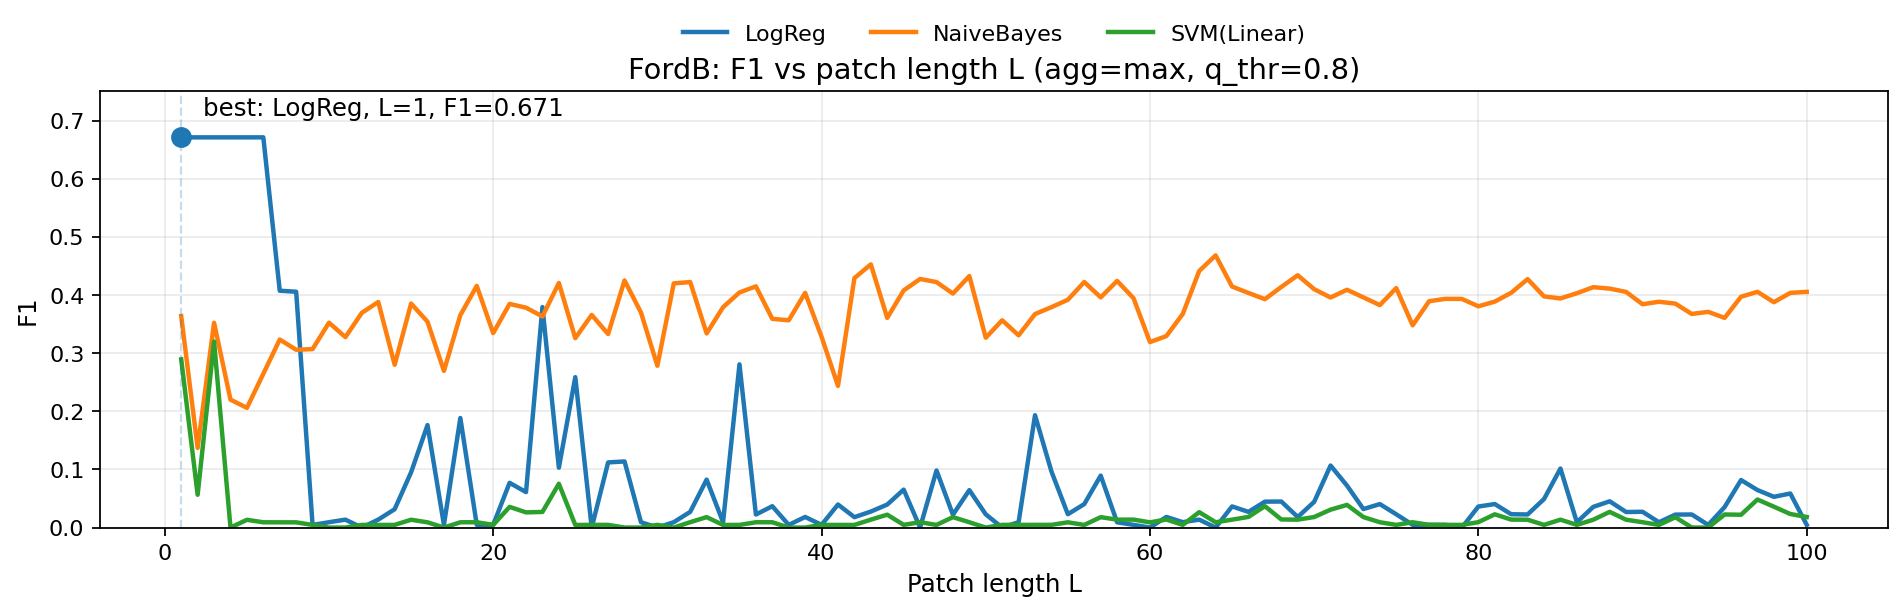

Saved PNG: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_f1_vs_L_top1_aggmax_q0.8.png
Saved PDF: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_f1_vs_L_top1_aggmax_q0.8.pdf

Global best points:
AUC: {'best_model': 'LogReg', 'best_L': 11, 'best_value': 0.589022553640349}
F1 : {'best_model': 'LogReg', 'best_L': 1, 'best_value': 0.6710418375717802}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

models = ["LogReg", "NaiveBayes", "SVM(Linear)"]

def plot_metric_vs_L_top1(df_full, metric, title, ylabel, fname_base, results_dir,
                          save_pdf=True, ylim=None):
    """
    Рисует metric(L) для всех моделей, подписывает только глобальный top-1
    Сохраняет PNG (и опционально PDF) в results_dir.
    """
    results_dir = Path(results_dir)
    results_dir.mkdir(parents=True, exist_ok=True)

    # --- подготовка ---
    plt.figure(figsize=(12,4), dpi=160)

    # для поиска глобального best
    best_model, best_L, best_val = None, None, -np.inf

    for model in models:
        tmp = df_full[df_full["model"] == model].sort_values("L")
        x = tmp["L"].to_numpy()
        y = tmp[metric].to_numpy()

        plt.plot(x, y, linewidth=2, label=model)

        # локальный best модели (чтобы найти глобальный best)
        i = int(np.argmax(y))
        if float(y[i]) > best_val:
            best_val = float(y[i])
            best_L = int(x[i])
            best_model = model

    # отметить и подписать best
    tmp_best = df_full[df_full["model"] == best_model].sort_values("L")
    y_best = float(tmp_best[tmp_best["L"] == best_L][metric].iloc[0])

    plt.scatter([best_L], [y_best], s=70)
    plt.annotate(
        f"best: {best_model}, L={best_L}, {metric}={y_best:.3f}",
        (best_L, y_best),
        textcoords="offset points",
        xytext=(10, 10),
        fontsize=11
    )
    plt.axvline(best_L, linestyle="--", linewidth=1, alpha=0.25)


    plt.title(title, fontsize=13)
    plt.xlabel("Patch length L", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, alpha=0.25)
    plt.legend(ncol=3, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.20))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.tight_layout()


    out_png = results_dir / f"{fname_base}.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    if save_pdf:
        out_pdf = results_dir / f"{fname_base}.pdf"
        plt.savefig(out_pdf, bbox_inches="tight")

    plt.show()
    print("Saved PNG:", out_png)
    if save_pdf:
        print("Saved PDF:", out_pdf)

    return {"best_model": best_model, "best_L": best_L, "best_value": best_val}

# AUC vs L
best_auc = plot_metric_vs_L_top1(
    df_full,
    metric="AUC",
    title=f"FordB: AUC vs patch length L (agg={agg_series}, q_thr={q_thr})",
    ylabel="AUC",
    fname_base=f"fordb_auc_vs_L_top1_agg{agg_series}_q{q_thr}",
    results_dir=RESULTS_DIR,
    save_pdf=True,
    ylim=(0.35, 0.65)

# F1 vs L
best_f1 = plot_metric_vs_L_top1(
    df_full,
    metric="F1",
    title=f"FordB: F1 vs patch length L (agg={agg_series}, q_thr={q_thr})",
    ylabel="F1",
    fname_base=f"fordb_f1_vs_L_top1_agg{agg_series}_q{q_thr}",
    results_dir=RESULTS_DIR,
    save_pdf=True,
    ylim=(0.0, 0.75)
)

print("\nGlobal best points:")
print("AUC:", best_auc)
print("F1 :", best_f1)


      model  L      AUC       F1  pred_pos_rate      thr
     LogReg  1 0.500000 0.671042       1.000000 0.500000
 NaiveBayes 64 0.547939 0.468085       0.365432 0.702152
SVM(Linear)  3 0.545933 0.319859       0.197531 0.000417


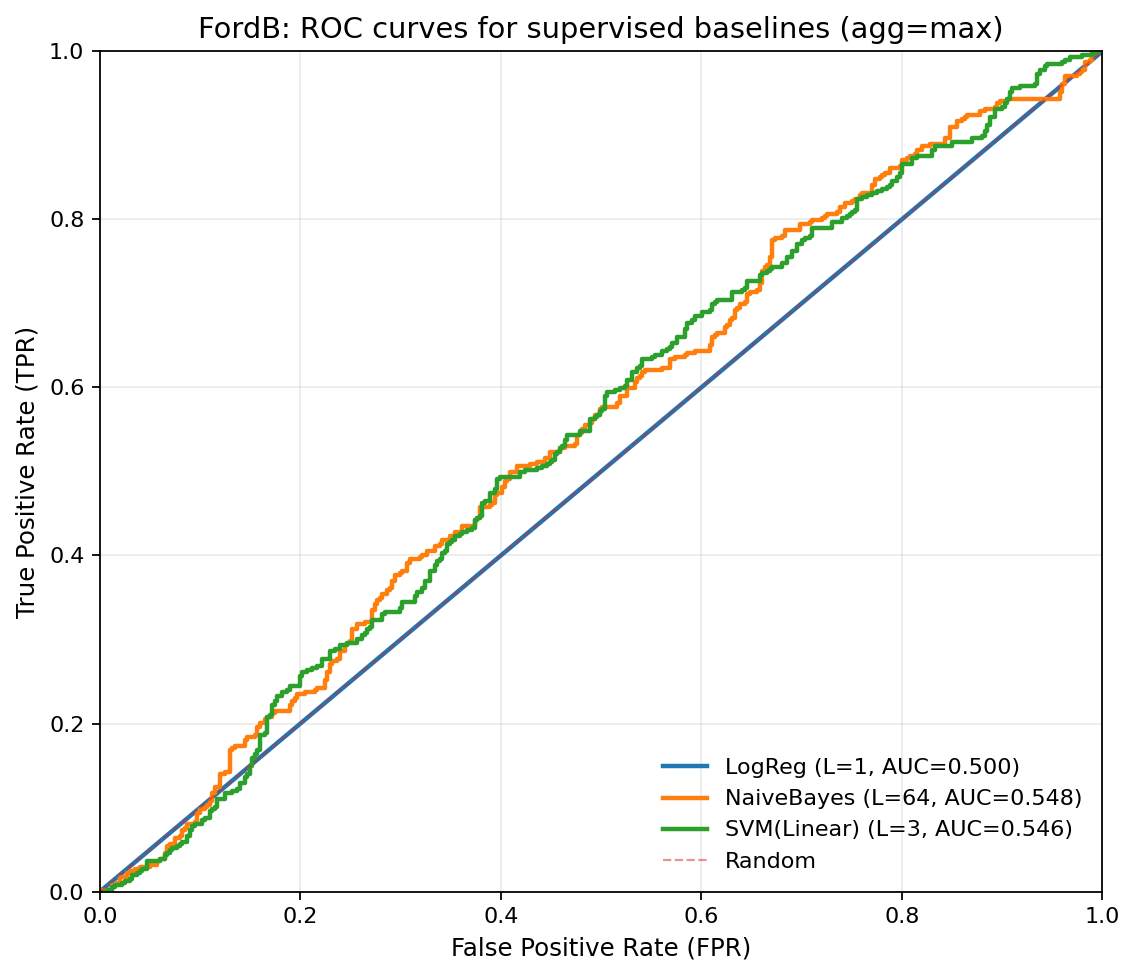

Saved PNG: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_roc_bestL_per_model_aggmax_q0.8.png
Saved PDF: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_roc_bestL_per_model_aggmax_q0.8.pdf


In [ ]:
def get_series_scores_supervised(X_train, y_train01, X_test, y_test01, model, L, agg_series="max"):
    # z-score per series
    Xtr = zscore_per_series(X_train)
    Xte = zscore_per_series(X_test)

    # patches (stride=L)
    Xtr_p, ytr_p, sid_tr, _ = make_patches_no_overlap(Xtr, y_train01, L)
    Xte_p, yte_p, sid_te, _ = make_patches_no_overlap(Xte, y_test01, L)

    n_test_series = len(y_test01)

    # scaling
    scaler = StandardScaler()
    Xtr_ps = scaler.fit_transform(Xtr_p)
    Xte_ps = scaler.transform(Xte_p)

    if model == "LogReg":
        clf = LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs")
        clf.fit(Xtr_ps, ytr_p)
        score_te_patch = clf.predict_proba(Xte_ps)[:, 1]

    elif model == "NaiveBayes":
        clf = GaussianNB()
        clf.fit(Xtr_ps, ytr_p)
        score_te_patch = clf.predict_proba(Xte_ps)[:, 1]

    elif model == "SVM(Linear)":
        clf = LinearSVC(class_weight="balanced", max_iter=10000)
        clf.fit(Xtr_ps, ytr_p)
        score_te_patch = clf.decision_function(Xte_ps)

    else:
        raise ValueError("Unknown model")

    # series-level score
    score_te_series = series_scores_from_patch_scores(score_te_patch, sid_te, n_test_series, agg=agg_series)
    return score_te_series


best_by_model = (
    df_full.sort_values(["model","F1"], ascending=[True, False])
           .groupby("model", as_index=False)
           .head(1)
)

print(best_by_model[["model","L","AUC","F1","pred_pos_rate","thr"]].to_string(index=False))

# ROC plot
RESULTS_DIR = Path(RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(7.2, 6.2), dpi=160)

for _, row in best_by_model.iterrows():
    model = row["model"]
    Lbest = int(row["L"])

    score = get_series_scores_supervised(
        X_train, y_train01, X_test, y_test01,
        model=model, L=Lbest, agg_series=agg_series
    )

    fpr, tpr, _ = roc_curve(y_test01, score)
    auc = roc_auc_score(y_test01, score)

    plt.plot(fpr, tpr, linewidth=2, label=f"{model} (L={Lbest}, AUC={auc:.3f})")

# диагональ случайного классификатора
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, alpha=0.5, label="Random")

plt.title(f"FordB: ROC curves for supervised baselines (agg={agg_series})", fontsize=13)
plt.xlabel("False Positive Rate (FPR)", fontsize=11)
plt.ylabel("True Positive Rate (TPR)", fontsize=11)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, loc="lower right")
plt.tight_layout()

out_png = RESULTS_DIR / f"fordb_roc_bestL_per_model_agg{agg_series}_q{q_thr}.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")

out_pdf = RESULTS_DIR / f"fordb_roc_bestL_per_model_agg{agg_series}_q{q_thr}.pdf"
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()
print("Saved PNG:", out_png)
print("Saved PDF:", out_pdf)


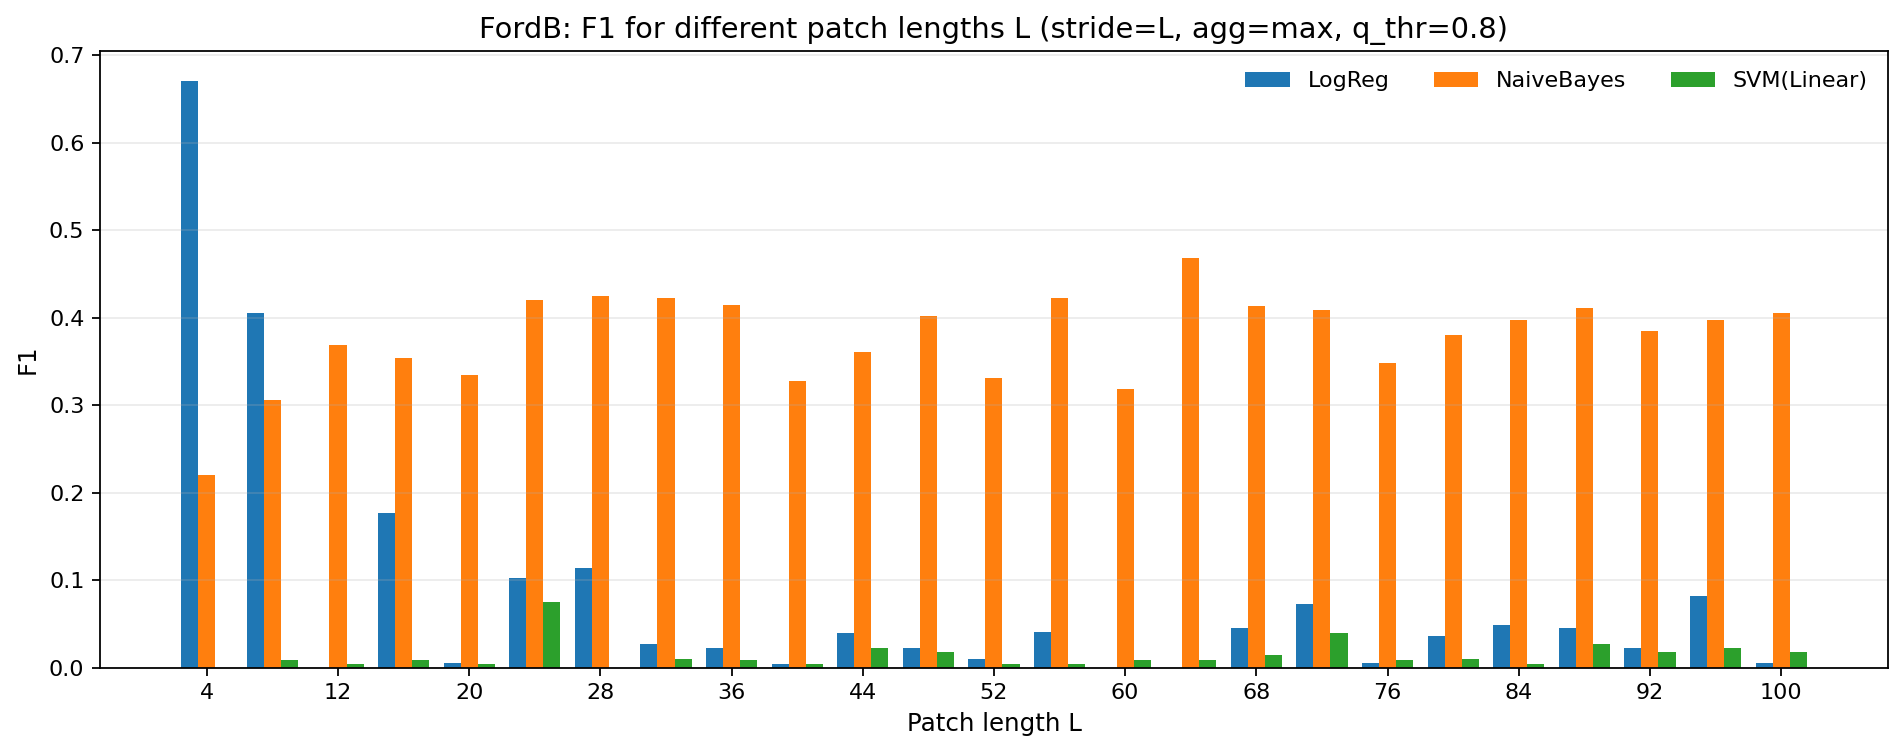

Saved PNG: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_bar_F1_by_L_3models_aggmax_q0.8.png
Saved PDF: /content/drive/MyDrive/Colab Notebooks/FordB/results/patching_baseline/fordb_bar_F1_by_L_3models_aggmax_q0.8.pdf

Best by model (F1):
      model  L       F1      AUC  pred_pos_rate
     LogReg  1 0.671042 0.500000       1.000000
 NaiveBayes 64 0.468085 0.547939       0.365432
SVM(Linear)  3 0.319859 0.545933       0.197531


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

MODELS = ["LogReg", "NaiveBayes", "SVM(Linear)"]
metric = "F1"                  # можно заменить на "AUC"
out_name = f"fordb_bar_{metric}_by_L_3models_agg{agg_series}_q{q_thr}"

df_bar = df_full[df_full["model"].isin(MODELS)].copy()

L_show = [L for L in sorted(df_bar["L"].unique()) if (L % 4 == 0)]
if len(L_show) == 0:
    L_show = sorted(df_bar["L"].unique())

df_bar = df_bar[df_bar["L"].isin(L_show)]

pv = df_bar.pivot_table(index="L", columns="model", values=metric, aggfunc="first").sort_index()

best_overall = df_full.loc[df_full["F1"].idxmax()]
top_model = best_overall["model"]
top_L = int(best_overall["L"])
top_val = float(best_overall["F1"])

plt.figure(figsize=(12, 4.8), dpi=160)

x = np.arange(len(pv.index))
width = 0.26

# смещение для групп
offsets = np.linspace(-width, width, num=len(MODELS))

for j, m in enumerate(MODELS):
    y = pv[m].values
    plt.bar(x + offsets[j], y, width=width, label=m)

# оси/подписи
plt.title(f"FordB: {metric} for different patch lengths L (stride=L, agg={agg_series}, q_thr={q_thr})", fontsize=13)
plt.xlabel("Patch length L", fontsize=11)
plt.ylabel(metric, fontsize=11)

tick_step = 2 if len(pv.index) <= 30 else 4
plt.xticks(x[::tick_step], pv.index.values[::tick_step], rotation=0)

plt.grid(True, axis="y", alpha=0.25)
plt.legend(frameon=False, ncol=3, loc="upper right")
plt.tight_layout()

if top_L in pv.index and top_model in MODELS:
    j = MODELS.index(top_model)
    i = list(pv.index).index(top_L)
    x_bar = x[i] + offsets[j]
    y_bar = pv.loc[top_L, top_model]

    plt.scatter([x_bar], [y_bar], s=40, zorder=5)  # отметим точку
    plt.text(x_bar, y_bar + 0.01, f"best: {top_model}\nL={top_L}, F1={y_bar:.3f}",
             ha="center", va="bottom", fontsize=9)

RESULTS_DIR = Path(RESULTS_DIR)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

out_png = RESULTS_DIR / f"{out_name}.png"
out_pdf = RESULTS_DIR / f"{out_name}.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()
print("Saved PNG:", out_png)
print("Saved PDF:", out_pdf)

best_by_model = (
    df_full.sort_values(["model", "F1"], ascending=[True, False])
           .groupby("model", as_index=False)
           .head(1)
           .sort_values("F1", ascending=False)
)
print("\nBest by model (F1):")
print(best_by_model[["model","L","F1","AUC","pred_pos_rate"]].to_string(index=False))
